In [1]:
import numpy as np
import h5py
import matplotlib
import torch.nn as nn
import torchvision
from torch.nn import Module
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import os


# Load .npy file using numpy
input_dir = "/media/muller_group/dm852_ExPro/ZSense/shared_hackathon/test/z1_4_33-x01.04-y00.82_noTDS_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc.hdf5"
output_dir = "/media/muller_group/dm852_ExPro/ZSense/shared_hackathon/test/z1_4_33-x01.04-y00.82_TDS64iso_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc.hdf5"
label_dir = "/media/muller_group/dm852_ExPro/ZSense/shared_hackathon/test_Z_map/z1_4_33-x01.04-y00.82.npy"

tempNoT = h5py.File(input_dir, 'r')
input_data = tempNoT['array'][:]  # Shape (batch_size, channels, height, width)

tempTDS = h5py.File(input_dir, 'r')
output_data = tempTDS['array'][:]  # Shape (batch_size, channels, height, width)

label_data = np.load(label_dir)  # Shape (batch_size, label_dim)

# Convert numpy arrays to PyTorch tensors
input_tensor = torch.tensor(input_data, dtype=torch.float32)
output_tensor = torch.tensor(output_data, dtype=torch.float32)
label_tensor = torch.tensor(label_data, dtype=torch.float32)

# Check shapes
print(f"Input tensor shape: {input_tensor.shape}")
print(f"Output tensor shape: {output_tensor.shape}")
print(f"Label tensor shape: {label_tensor.shape}")


Input tensor shape: torch.Size([59, 59, 64, 64])
Output tensor shape: torch.Size([59, 59, 64, 64])
Label tensor shape: torch.Size([59, 59])


In [2]:
# Check shapes
print(f"Input tensor shape: {input_tensor.shape}")
print(f"Output tensor shape: {output_tensor.shape}")
print(f"Label tensor shape: {label_tensor.shape}")

Input tensor shape: torch.Size([59, 59, 64, 64])
Output tensor shape: torch.Size([59, 59, 64, 64])
Label tensor shape: torch.Size([59, 59])


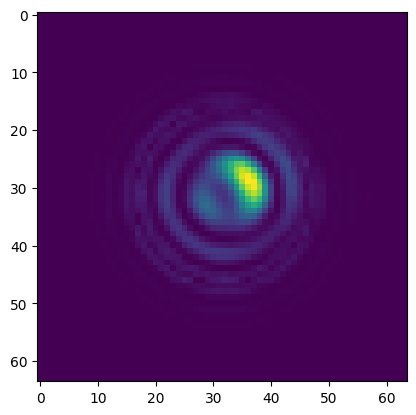

In [3]:
plt.imshow(input_tensor[5,5,:,:])

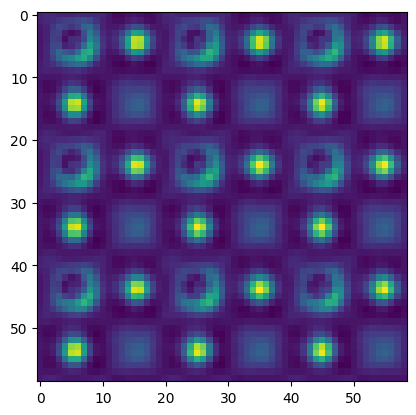

In [4]:
plt.imshow(input_tensor[:,:,32,32])

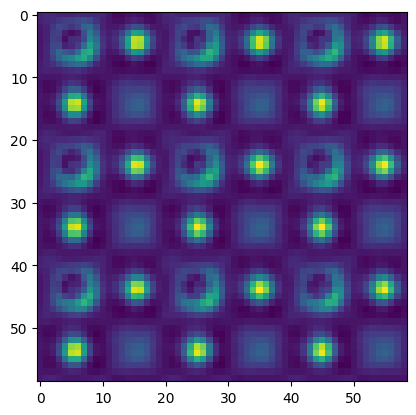

In [5]:
plt.imshow(output_tensor[:,:,32,32])

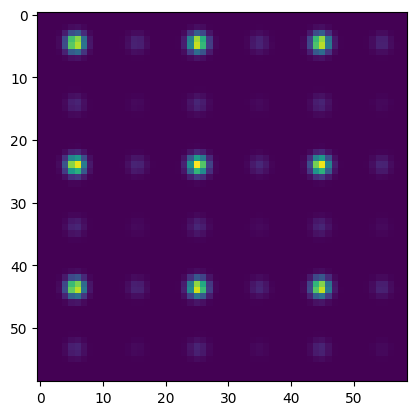

In [6]:
plt.imshow(label_tensor)

In [7]:
import torch
import torch.nn as nn

class ConditionalUNet(nn.Module):
    def __init__(self, img_channels=1, label_dim=1, output_channels=1):
        super(ConditionalUNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(img_channels + label_dim, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)

        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)

        # Decoder
        self.dec3 = self.upconv_block(512 + 256, 256)
        self.dec2 = self.upconv_block(256 + 128, 128)
        self.dec1 = self.upconv_block(128 + 64, 64)

        # Final Output Layer
        self.final = nn.Conv2d(64, output_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            self.conv_block(out_channels, out_channels)
        )

    def forward(self, img, label):
        # Expand label to image size
        label_img = label.view(-1, 1, 1, 1).expand(-1, 1, img.shape[2], img.shape[3])
        combined_input = torch.cat([img, label_img], dim=1)

        # U-Net Path
        enc1 = self.enc1(combined_input)
        enc2 = self.enc2(nn.functional.max_pool2d(enc1, 2))
        enc3 = self.enc3(nn.functional.max_pool2d(enc2, 2))
        bottleneck = self.bottleneck(nn.functional.max_pool2d(enc3, 2))

        dec3 = self.dec3(torch.cat((nn.functional.interpolate(bottleneck, scale_factor=2), enc3), dim=1))
        dec2 = self.dec2(torch.cat((nn.functional.interpolate(dec3, scale_factor=2), enc2), dim=1))
        dec1 = self.dec1(torch.cat((nn.functional.interpolate(dec2, scale_factor=2), enc1), dim=1))

        final_output = self.final(dec1)
        return final_output


In [11]:
import torch
from torch.utils.data import DataLoader, Dataset

# Updated Dataset Class
class CustomDataset(Dataset):
    def __init__(self, input_data, label_data, output_data):
        self.input_data = input_data
        self.label_data = label_data
        self.output_data = output_data

    def __len__(self):
        return self.input_data.shape[0] * self.input_data.shape[1]

    def __getitem__(self, idx):
        # Find correct index in 2D structure
        i = idx // self.input_data.shape[1]
        j = idx % self.input_data.shape[1]

        # Extract image, label, and target
        image = self.input_data[i, j].unsqueeze(0)    # Shape (1, 64, 64)
        label = self.label_data[i, j].unsqueeze(0)   # Shape (1,)
        target = self.output_data[i, j].unsqueeze(0) # Shape (1, 64, 64)

        return image, label, target


# # Initialize Data
# input_tensor = torch.randn(59, 59, 64, 64)   # Example input
# label_tensor = torch.randint(0, 5, (59, 59)) # Example labels (integers)
# output_tensor = torch.randn(59, 59, 64, 64)  # Example target output

# Create Dataset and DataLoader
dataset = CustomDataset(input_tensor, label_tensor, output_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize Model, Loss, and Optimizer
model = ConditionalUNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Split Dataset into Training and Testing Sets (80:20)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Track Training and Testing Loss
train_losses = []
test_losses = []

# Training Loop
num_epochs = 50
# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    
    # Training Loop with Progress Bar
    loop = tqdm(train_loader, total=len(train_loader), leave=True)
    for image, label, target in loop:
        # Move data to GPU
        image, label, target = image.to(device), label.to(device), target.to(device)

        optimizer.zero_grad()

        # Forward pass
        prediction = model(image, label)

        # Calculate Loss and Backpropagation
        loss = criterion(prediction, target)
        loss.backward()
        optimizer.step()

        # Update Progress Bar
        running_train_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    # Average Training Loss
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on Test Set
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for image, label, target in test_loader:
            image, label, target = image.to(device), label.to(device), target.to(device)
            prediction = model(image, label)

            # Calculate Test Loss
            test_loss = criterion(prediction, target)
            running_test_loss += test_loss.item()

    # Average Test Loss
    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    print(f"Epoch [{epoch+1}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")


# Plot Training and Testing Loss Curves with Log Scale
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o', color='b')
plt.plot(range(1, num_epochs+1), test_losses, label='Testing Loss', marker='s', color='r')

plt.title("Training and Testing Loss (Log Scale)")
plt.xlabel("Epoch")
plt.ylabel("Loss (Log Scale)")
plt.yscale('log')  # Apply log scale to y-axis
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()



Using device: cuda


NameError: name 'IntoInelastic2D' is not defined

In [10]:
# Switch model to evaluation mode
model.eval()

# Select specific input sample
sample_input = input_tensor[5, 5, :, :].unsqueeze(0).unsqueeze(0).to(device)  # Shape: (1, 1, 64, 64)
sample_label = label_tensor[5, 5].item()

# Combine input and label into a two-channel tensor
combined_input = torch.cat((sample_input, torch.full_like(sample_input, sample_label)), dim=1)

# Make a prediction
with torch.no_grad():
    prediction = model(combined_input)
    pred_img = prediction.squeeze().cpu().numpy()

# Plot the images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Original Input
ax[0].imshow(sample_input.squeeze().cpu().numpy(), cmap='gray')
ax[0].set_title("Input Image")

# Ground Truth (Assuming output_tensor is available)
target_img = output_tensor[5, 5, :, :].cpu().numpy()
ax[1].imshow(target_img, cmap='gray')
ax[1].set_title("Target Image")

# Predicted Output
ax[2].imshow(pred_img, cmap='gray')
ax[2].set_title("Predicted Image")

plt.show()


NameError: name 'model' is not defined